In [1]:
import pandas as pd
import numpy as np
import sklearn
import os

In [2]:
# directories for csv files
csv_dir = 'PUF AY 2022/CSV/'
os.listdir(csv_dir)

['PUF Variable Formats.csv',
 'PUF_AIS15TO05_CROSSWALK.csv',
 'PUF_AISDIAGNOSIS.csv',
 'PUF_AISDIAGNOSIS_LOOKUP.csv',
 'PUF_Ecode_Lookup.csv',
 'PUF_HOSPITALEVENTS.csv',
 'PUF_ICDDIAGNOSIS.csv',
 'PUF_ICDDIAGNOSIS_LOOKUP.csv',
 'PUF_ICDPROCEDURE.csv',
 'PUF_ICDPROCEDURE_LOOKUP.csv',
 'PUF_PREEXISTINGCONDITIONS.csv',
 'PUF_TRAUMA.csv',
 'PUF_TRAUMA_LOOKUP.csv',
 'TQP_INCLUSION.csv']

In [3]:
# create a df for each one

os.listdir(csv_dir)

directory = csv_dir
# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Remove the first 4 characters, replace spaces with underscores, and create a dataframe name
        df_name = filename[4:].lower().replace('.csv', '').replace(' ', '_')
        
        # Try different encodings and handle spaces
        try:
            df = pd.read_csv(os.path.join(directory, filename), encoding='utf-8', skipinitialspace=True)
        except UnicodeDecodeError:
            df = pd.read_csv(os.path.join(directory, filename), encoding='latin1', skipinitialspace=True)
        
        # Assign the dataframe to a variable with the processed name
        globals()[df_name] = df

        print(f"Created dataframe: {df_name}")





Created dataframe: variable_formats
Created dataframe: ais15to05_crosswalk
Created dataframe: aisdiagnosis
Created dataframe: aisdiagnosis_lookup
Created dataframe: ecode_lookup
Created dataframe: hospitalevents
Created dataframe: icddiagnosis
Created dataframe: icddiagnosis_lookup
Created dataframe: icdprocedure
Created dataframe: icdprocedure_lookup
Created dataframe: preexistingconditions


C:\Users\micha\AppData\Local\Temp\ipykernel_27852\3218883938.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, filename), encoding='utf-8', skipinitialspace=True)


Created dataframe: trauma
Created dataframe: trauma_lookup
Created dataframe: inclusion


In [4]:
# will be using the trauma part
trauma.shape
# 231 different predictors; will need to determine which ones are not available to a physician, and then get rid of those
# then separate what we need as response variables


# transfusions, which ICD procedure code starts with 302:
transfusions = icdprocedure[icdprocedure['ICDPROCEDURECODE'].str.startswith('302') & icdprocedure['ICDPROCEDURECODE'].notnull()]

print(transfusions.shape)
# 200411 transfusions in this dataset

(200411, 6)


In [5]:

# Find the number of unique values in the first column 'inc_key'
unique_keys = trauma['inc_key'].nunique()

# Display the result
print(f'The number of unique values in the first column "inc_key" is: {unique_keys}')
# each one is a unique key

print(trauma.SBP_BIU.dropna())

The number of unique values in the first column "inc_key" is: 1232956
6          2.0
7          2.0
9          2.0
11         2.0
13         2.0
          ... 
1232687    2.0
1232694    2.0
1232753    2.0
1232833    2.0
1232874    2.0
Name: SBP_BIU, Length: 54597, dtype: float64


In [6]:
# will be removing ones not useful to the physician as a support decision algorithm

print("Column names in the 'trauma' DataFrame:")
# print(trauma.columns.tolist())
# not in the same order as the user manual. will need to go through each of these manually :'(


cols_to_remove =[
    'EDDISCHARGEDISPOSITION','EDDISCHARGEDISPOSITION_BIU','FINALDISCHARGEDH_BIU','FINALDISCHARGEHRS','FINALDISCHARGEDAYS','HOSPDISCHARGEDISPOSITION','HOSPDISCHARGEDISPOSITION_BIU',
    'WITHDRAWALLSTDAYS','WITHDRAWALLSTHRS','WITHDRAWALLSTDH_BIU','WITHDRAWALLST','WITHDRAWALLST_BIU','INPATIENTDAYS','INPATIENTHRS','INPATIENTDH_BIU',
    'TOTALICULOS','TOTALICULOS_BIU','EDDISCHARGEDAYS','EDDISCHARGEHRS','EDDISCHARGEDH_BIU',
# left off at page 26. seems procedures are next, so decide about that
]

cols_to_remove_retired = [
    'LOSDAYS','LOSMINS' # LOSDAYS and LOSMINS are retired after 2018, replaced by final discharge days and hrs
    'WITHDRAWALLSTMINS', # 2018
    'HOSPITALDISCHARGEDAYS','HOSPITALDISCHARGEHRS','HOSPITALDISCHARGEDH_BIU', # 2019
    'EDDAYS','EDMINS', # 2018
    'YODISCH', # 2018
]

# hospital complications appear to be retired, and in another dataset
hospital_complications = [
    'HC_KIDNEY', 'HC_RESPIRATORY','HC_ALCOHOLWITHDRAWAL','HC_CARDARREST','HC_CAUTI','HC_CLABSI','HC_DEEPSSI', 'HC_DVTHROMBOSIS','HC_EXTREMITYCS', 'HC_MI', 
    'HC_NA', 'HC_UK', 'HC_ORGANSPACESSI', 'HC_OSTEOMYELITIS','HC_OTHER','HC_PRESSUREULCER', 'HC_EMBOLISM', 'HC_SEPSIS','HC_STROKECVA','HC_SUPERFICIALINCISIONSSI','HC_UNPLANNEDICU',
    'HC_INTUBATION','HC_RETURNOR','HC_VAPNEUMONIA'
]

in_hospital_actions = [
    'ANGIOGRAPHY','ANGIOGRAPHY_BIU','ANTIBIOTICTHERAPY','ANTIBIOTICTHERAPY_BIU','ICPO2MONITOR','ICPPARENCH','ICPEVDRAIN','ICPJVBULB','ICPNONE',
    'ICP_NA','ICP_UK', 'ESKIDNEY','ESLIVER','ES_NA','ES_UK','ESOTHER','ESPELVIS','ESVASCULAR','ESRETROPERI','ESSPLEEN',
]

in_hospital_actions_retired = [
    'ESAORTA' # 2019
]

all_type_transfusions_retired = [
    'CRYOPRECIPITATE24HOURS','CRYOPRECIPITATE24HOURS_BIU',  # 2018
    'CRYOPRECIPITATECONVERSION', 'CRYOPRECIPITATECONVERSION_BIU','CRYOPRECIPITATEMEASURE','CRYOPRECIPITATEMEASURE_BIU', # 2019
    'BLOOD24HOURS','BLOOD24HOURS_BIU', # 2018
    'BLOODCONVERSION','BLOODCONVERSION_BIU','BLOODMEASURE','BLOODMEASURE_BIU','PLASMA24HOURS','PLASMA24HOURS_BIU', #2019
    'PLASMACONVERSION','PLASMACONVERSION_BIU','PLASMAMEASURE','PLASMAMEASURE_BIU', # 2019
    'PLATELETS24HOURS','PLATELETS24HOURS_BIU', # 2018
    'PLATELETSCONVERSION','PLATELETSCONVERSION_BIU','PLATELETSMEASURE','PLATELETSMEASURE_BIU', # 2019
]

all_type_transfusions = [
    'CRYOPRECIPITATE4HOURS','CRYOPRECIPITATE4HOURS_BIU',
    'BLOOD4HOURS','BLOOD4HOURS_BIU','PLASMA4HOURS','PLASMA4HOURS_BIU', 'PLATELETS4HOURS','PLATELETS4HOURS_BIU',
    'WHOLEBLOOD4HOURS','WHOLEBLOOD4HOURS_BIU',
]




# not sure if i entirely understand these--they will likely be removed, so let us remove them anyways.
not_sure_if_remove = [ 
    'ANGIOGRAPHYDAYS','ANGIOGRAPHYHRS','ANGIOGRAPHYDH_BIU', # angiography, check retired
    'ANTIBIOTICTHERAPYDAYS','ANTIBIOTICTHERAPYHRS','ANTIBIOTICTHERAPYDH_BIU', # abx therapy
    'TBICEREBRALMONITORDAYS','TBICEREBRALMONITORHRS','TBICEREBRALMONITORDH_BIU', # cerebral monitoring, check retired
    'HMRRHGCTRLSURGDAYS','HMRRHGCTRLSURGHRS','HMRRHGCTRLSURGDH_BIU','HMRRHGCTRLSURGTYPE','HMRRHGCTRLSURGTYPE_BIU', # surgery for hemorrhage control, check retired
    'VTEPROPHYLAXISDAYS','VTEPROPHYLAXISHRS','VTEPROPHYLAXISDH_BIU', # VTE proph, check retired
    'VTEPROPHYLAXISTYPE','VTEPROPHYLAXISTYPE_BIU', # are these relating to VTE proph above? i assume yes
    'TOTALVENTDAYS','TOTALVENTDAYS_BIU', # total vent days
]

not_sure_if_remove_retired = [
    'ANGIOGRAPHYMINS', # 2018
    'CEREBRALMONITORMINS','CEREBRALMONITORDAYS' # 2018
    'HMRRHGCTRLSURGMINS', # 2018
    'VTEPROPHYLAXISMINS', # 2018
]



all_removals = cols_to_remove + not_sure_if_remove + all_type_transfusions + in_hospital_actions


# Remove the columns listed in 'cols_to_remove' from the DataFrame 
trauma_relevant = trauma.drop(columns=all_removals)

# for now remove the hospital complications
# trauma_relevant = trauma_relevant.drop(columns=hospital_complications) # not in trauma?

# remaining_cols = trauma_relevant.columns.tolist()

# for col in remaining_cols:
#     print(col)


print(f'before removal: {trauma.shape}')
print(f'after removal: {trauma_relevant.shape}')

Column names in the 'trauma' DataFrame:
before removal: (1232956, 231)
after removal: (1232956, 160)


Here is some notes about which ones you may or may not want to remove, will update as go on:

LOWESTSBP and LOWESTSBP_BIU potentially. This one seems like it may be very useful, but also not sure how much this would be available. Definitely discuss with the trauma surgeons for this.

will PRIMARYECODEICD10 and PRIMARYECODEICD10_BIU potentially have any information, such as 'disease requiring transfusion'? plus the additional codes

In [7]:
# remove ones that we will disqualify
# main goal is to disqualify ones of head, using AIS. completely different picture

In [8]:
# remove the portions that are related to trauma. change them into a dummy variable for general transfusions, you have the transfusions df that you can use to create a dummy variable

# Create a new DataFrame with the dummy variable
trauma_transfusions = trauma_relevant.copy()
trauma_transfusions['transfusion'] = trauma_relevant['inc_key'].isin(transfusions['Inc_Key'])

# Display the new DataFrame
print(f'shape of df: {trauma_transfusions.shape}')
print(f'total number of transfusions in dataset: {trauma_transfusions['transfusion'].sum()}')


shape of df: (1232956, 161)
total number of transfusions in dataset: 109819


# Preprocessing
To do:
- near zero var
- imputation
- remove largely empty ones
- multicolinearity/correlation? perhaps not a huge deal here

In [9]:
trauma_preprocessed = trauma_transfusions

# drop all BIU; not relevant to prediction
trauma_preprocessed = trauma_preprocessed.drop(columns=[col for col in trauma_preprocessed.columns if col.endswith('BIU')])

# Display the updated DataFrame
print("Updated DataFrame:")
print(trauma_preprocessed.head())



Updated DataFrame:
        inc_key  SEX  AgeYears  AMERICANINDIAN  ASIAN  BLACK  PACIFICISLANDER  \
0  220063506730  2.0       5.0               0      0      0                0   
1  220063506731  1.0      13.0               0      0      0                0   
2  220063506732  1.0      14.0               0      0      1                0   
3  220063506733  1.0      11.0               0      0      0                0   
4  220063506734  2.0       6.0               0      0      0                0   

   RACEOTHER  WHITE  RACE_NA  ...  GCS40VERBAL  TBIGCS40MOTOR  TEACHINGSTATUS  \
0          0      1        0  ...          NaN            NaN             5.0   
1          1      0        0  ...          NaN            NaN             5.0   
2          0      0        0  ...          NaN            NaN             5.0   
3          0      1        0  ...          NaN            NaN             5.0   
4          0      1        0  ...          NaN            NaN             5.0   

   HOSP

In [10]:
# get the categorical and continuous features
categorical_features = []
continuous_features = []

for column in trauma_preprocessed.columns:
    # print(trauma_transfusions[column].dtype)
    if pd.api.types.is_numeric_dtype(trauma_preprocessed[column]):
        continuous_features.append(column)
    else:
        categorical_features.append(column)

# Display the result
print("Continuous columns:", continuous_features)
# print("Categorical columns:", categorical_features)
# output: Categorical columns: ['PLACEOFINJURYCODE', 'PRIMARYECODEICD10', 'ADDITIONALECODE1', 'ADDITIONALECODE2', 'ISSVersion']
# for col in continuous_features:
#     print(col)
trauma_preprocessed = trauma_preprocessed.drop(columns=categorical_features)

Continuous columns: ['inc_key', 'SEX', 'AgeYears', 'AMERICANINDIAN', 'ASIAN', 'BLACK', 'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK', 'ETHNICITY', 'WORKRELATED', 'PTOCCUPATIONALINDUSTRY', 'PATIENTSOCCUPATION', 'PROTDEV_NONE', 'PROTDEV_LAP_BELT', 'PROTDEV_PER_FLOAT', 'PROTDEV_PROTECT_GEAR', 'PROTDEV_EYE_PROTECT', 'PROTDEV_CHILD_RESTRAINT', 'PROTDEV_HELMET', 'PROTDEV_AIRBAG_PRESENT', 'PROTDEV_PROTECT_CLOTH', 'PROTDEV_SHOULDER_BELT', 'PROTDEV_OTHER', 'PROTDEV_NA', 'PROTDEV_UK', 'CHILDSPECIFICRESTRAINT', 'AIRBAG_NOTDEPLOYED', 'AIRBAG_DEPLOYED_FRNT', 'AIRBAG_DEPLOYED_SIDE', 'AIRBAG_DEPLOYED_OTHER', 'AIRBAG_DEPLOYED_NA', 'AIRBAG_DEPLOYED_UK', 'TRANSPORTMODE', 'TM_GROUNDAMBULANCE', 'TM_HELICOPTERAMBULANCE', 'TM_FIXEDWINGAMBULANCE', 'TM_PRIVPUBVEHWALKIN', 'TM_POLICE', 'TM_OTHER', 'TM_NA', 'TM_UK', 'INTERFACILITYTRANSFER', 'PREHOSPITALCARDIACARREST', 'SBP', 'PULSERATE', 'TEMPERATURE', 'RESPIRATORYRATE', 'RESPIRATORYASSISTANCE', 'PULSEOXIMETRY', 'SUPPLEMENTALOXYGEN', 'HEIGHT', 'W

In [11]:
# binary encoding
binary_features = [
    'AMERICANINDIAN', 'ASIAN', 'BLACK', 'ETHNICITY',
    'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK', 'WORKRELATED', 
    'PROTDEV_NONE', 'PROTDEV_LAP_BELT', 'PROTDEV_PER_FLOAT', 'PROTDEV_PROTECT_GEAR', 
    'PROTDEV_EYE_PROTECT', 'PROTDEV_CHILD_RESTRAINT', 'PROTDEV_HELMET', 
    'PROTDEV_AIRBAG_PRESENT', 'PROTDEV_PROTECT_CLOTH', 'PROTDEV_SHOULDER_BELT', 
    'PROTDEV_OTHER', 'PROTDEV_NA', 'PROTDEV_UK', 'CHILDSPECIFICRESTRAINT', 
    'AIRBAG_NOTDEPLOYED', 'AIRBAG_DEPLOYED_FRNT', 'AIRBAG_DEPLOYED_SIDE', 
    'AIRBAG_DEPLOYED_OTHER', 'AIRBAG_DEPLOYED_NA', 'AIRBAG_DEPLOYED_UK', 
    'TRANSPORTMODE', 'TM_GROUNDAMBULANCE', 'TM_HELICOPTERAMBULANCE', 
    'TM_FIXEDWINGAMBULANCE', 'TM_PRIVPUBVEHWALKIN', 'TM_POLICE', 'TM_OTHER', 
    'TM_NA', 'TM_UK', 'INTERFACILITYTRANSFER', 'PREHOSPITALCARDIACARREST', 
    'RESPIRATORYASSISTANCE',  
    'GCSQ_SEDATEDPARALYZED', 'GCSQ_EYEOBSTRUCTION', 
    'GCSQ_INTUBATED', 'GCSQ_VALID', 'GCSQ_NA', 'GCSQ_UK', 'DRGSCR_AMPHETAMINE', 
    'DRGSCR_BARBITURATE', 'DRGSCR_BENZODIAZEPINES', 'DRGSCR_COCAINE', 
    'DRGSCR_METHAMPHETAMINE', 'DRGSCR_ECSTASY', 'DRGSCR_METHADONE', 'DRGSCR_OPIOID', 
    'DRGSCR_OXYCODONE', 'DRGSCR_PHENCYCLIDINE', 'DRGSCR_TRICYCLICDEPRESS', 
    'DRGSCR_CANNABINOID', 'DRGSCR_OTHER', 'DRGSCR_NONE', 'DRGSCR_NOTTESTED', 
    'DRGSCR_UK', 'DRGSCR_NA', 
    'PMGCSQ_SEDATEDPARALYZED', 'PMGCSQ_EYEOBSTRUCTION', 
    'PMGCSQ_INTUBATED', 'PMGCSQ_VALID', 'PMGCSQ_NA', 'PMGCSQ_UK', 
    'HOMERESIDENCE_HOMELESS', 
    'HOMERESIDENCE_UK', 'HOMERESIDENCE_NA', 'HomeResidence_Other',  
    'SUPPLEMENTALOXYGEN','ALCOHOLSCREEN','HIGHESTACTIVATION',
]

# OH encoding
onehot_features = [
    'SEX', 'ETHNICITY','TBIMIDLINESHIFT', 
    'TEACHINGSTATUS', 
]


# label encoding
label_features = [
    'PTOCCUPATIONALINDUSTRY', 'PATIENTSOCCUPATION', 'PRIMARYMETHODPAYMENT', 
    'TBIPUPILLARYRESPONSE','HOSPITALTYPE', 'Bedsize', 
    'VERIFICATIONLEVEL', 'PEDIATRICVERIFICATIONLEVEL', 'STATEDESIGNATION', 'STATEPEDIATRICDESIGNATION', 
]

# numerical features that do not need encoding
number_features = [ 
    'AgeYears', 'SBP', 'PULSERATE', 'TEMPERATURE', 'RESPIRATORYRATE',
    'PULSEOXIMETRY', 'HEIGHT', 'WEIGHT', 
    'GCSEYE', 'GCSVERBAL', 'GCSMOTOR', 'TOTALGCS',  
    'ALCOHOLSCREENRESULT', 'HOSPITALARRIVALHRS', 'HOSPITALARRIVALDAYS', 
    'TBIHIGHESTTOTALGCS', 'TBIGCSMOTOR', 
    'ISS', 'TRAUMASURGEONARRIVALHRS', 'TRAUMASURGEONARRIVALDAYS', 
    'GCS40EYE', 'GCS40MOTOR', 'GCS40VERBAL', 'TBIGCS40MOTOR', 
]

In [12]:
# print(trauma_transfusions.shape)
# print(trauma_preprocessed.shape)
# trauma_preprocessed['STATEDESIGNATION'].value_counts()
# from collections import Counter
# combined = binary_features + onehot_features + label_features + number_features

# item_counts = Counter(combined)

# # Print items that appear more than once
# print("Values found more than once across the lists:")
# for item, count in item_counts.items():
#     if count > 1:
#         print(item)


print(len(continuous_features) - len(binary_features) - len(onehot_features) - len(label_features) - len(number_features))

1


In [13]:
from sklearn.feature_selection import VarianceThreshold

variances = trauma_preprocessed.var()
variance_threshold = 0.01

# Find features with variance close to zero or exactly zero (degenerate)
low_variance_features = variances[variances <= variance_threshold].index.tolist()

# Print the results
print("Features with degenerate or near-zero variance:")
for feature in low_variance_features:
    print(f"{feature}: Variance = {variances[feature]}")
print(len(low_variance_features))
# note: all the NA variables are purely false

# drop these features from trauma_preprocessed
trauma_preprocessed = trauma_preprocessed.drop(columns=low_variance_features)
trauma_preprocessed.shape

Features with degenerate or near-zero variance:
AMERICANINDIAN: Variance = 0.00894719792667483
PACIFICISLANDER: Variance = 0.0028362955226866327
RACE_NA: Variance = 0.0
PROTDEV_PER_FLOAT: Variance = 0.00015569919512060685
PROTDEV_PROTECT_GEAR: Variance = 0.003602630433303224
PROTDEV_EYE_PROTECT: Variance = 0.0007755815844469267
PROTDEV_CHILD_RESTRAINT: Variance = 0.0017924614884640942
PROTDEV_PROTECT_CLOTH: Variance = 0.006824882234524307
PROTDEV_OTHER: Variance = 0.001847412428735045
PROTDEV_NA: Variance = 0.0
AIRBAG_DEPLOYED_OTHER: Variance = 0.0059994734819493935
TM_HELICOPTERAMBULANCE: Variance = 0.0018538768452359912
TM_FIXEDWINGAMBULANCE: Variance = 0.001410869650332213
TM_POLICE: Variance = 0.0013671942723034614
TM_OTHER: Variance = 0.0026765934891277996
GCSQ_EYEOBSTRUCTION: Variance = 0.001972645511015936
GCSQ_NA: Variance = 0.0
DRGSCR_BARBITURATE: Variance = 0.003997822350984466
DRGSCR_ECSTASY: Variance = 0.0033714854247602027
DRGSCR_METHADONE: Variance = 0.001365576592109113


(1232956, 86)

In [14]:
# Calculate the proportion of missing data for each column
missing_data_proportion = trauma_preprocessed.isnull().mean()

# Filter columns with more than 90% missing data
high_missing_features = missing_data_proportion[missing_data_proportion > 0.90]

# Display the results
print("Columns with more than 90% missing data:")
for column, proportion in high_missing_features.items():
    print(f"{column}: {proportion:.2%}")


# # drop this data:
trauma_preprocessed = trauma_preprocessed.drop(columns=high_missing_features.index.tolist())
trauma_preprocessed.shape

Columns with more than 90% missing data:
PTOCCUPATIONALINDUSTRY: 97.08%
PATIENTSOCCUPATION: 97.13%
CHILDSPECIFICRESTRAINT: 99.82%
TRAUMASURGEONARRIVALHRS: 91.36%
TRAUMASURGEONARRIVALDAYS: 90.63%
GCS40EYE: 99.32%
GCS40MOTOR: 99.32%
GCS40VERBAL: 99.32%
TBIGCS40MOTOR: 99.57%


(1232956, 77)

In [15]:
# do imputation
from sklearn.impute import SimpleImputer

# update imp lists
# since we need the lists above for encoding, will filter to use only ones still existing:

binary_features = [col for col in binary_features if col in trauma_preprocessed.columns]
onehot_features = [col for col in onehot_features if col in trauma_preprocessed.columns]
label_features =  [col for col in label_features if col in trauma_preprocessed.columns]
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# print(binary_features)
trauma_preprocessed.shape



mode_imputer = SimpleImputer(strategy = 'most_frequent') # categorical variables: for binary, OH, and label lists above
categorical_imputation_columns = binary_features + onehot_features + label_features
trauma_preprocessed[categorical_imputation_columns] = mode_imputer.fit_transform(trauma_preprocessed[categorical_imputation_columns])

mean_imputer = SimpleImputer(strategy='mean') # for number features above
trauma_preprocessed[number_features] = mean_imputer.fit_transform(trauma_preprocessed[number_features])

Highly correlated pairs (above 0.9 correlation):
('GCSEYE', 'GCSMOTOR')
('GCSEYE', 'TOTALGCS')
('GCSVERBAL', 'TOTALGCS')
('GCSMOTOR', 'TOTALGCS')
('TBIHIGHESTTOTALGCS', 'TBIGCSMOTOR')


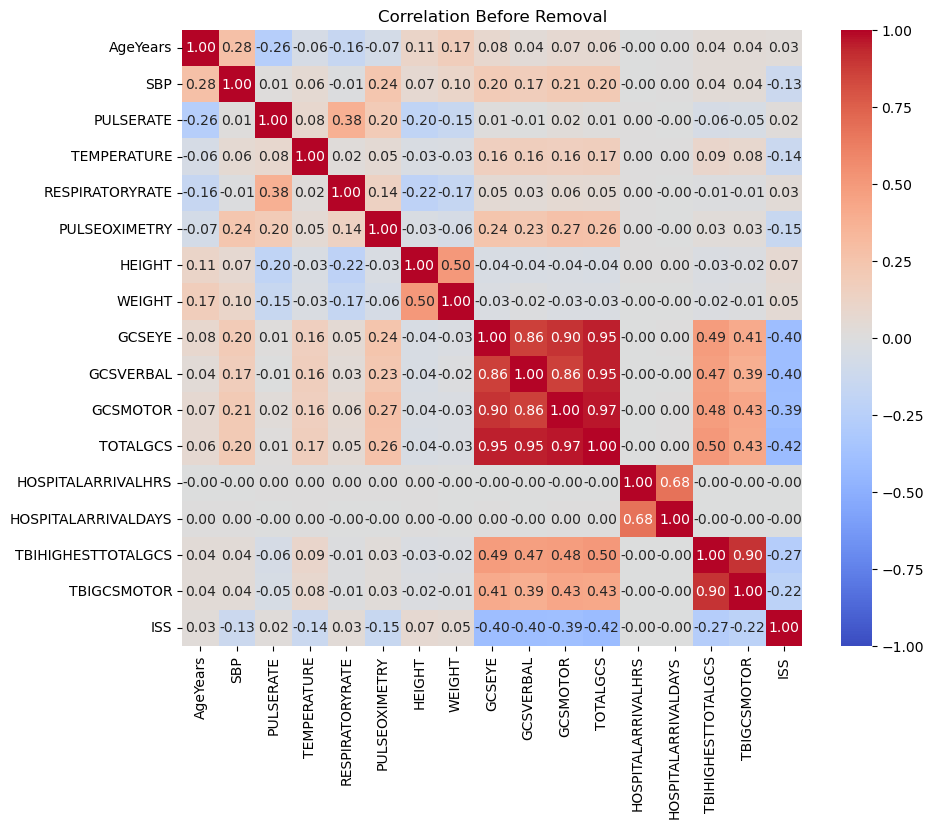

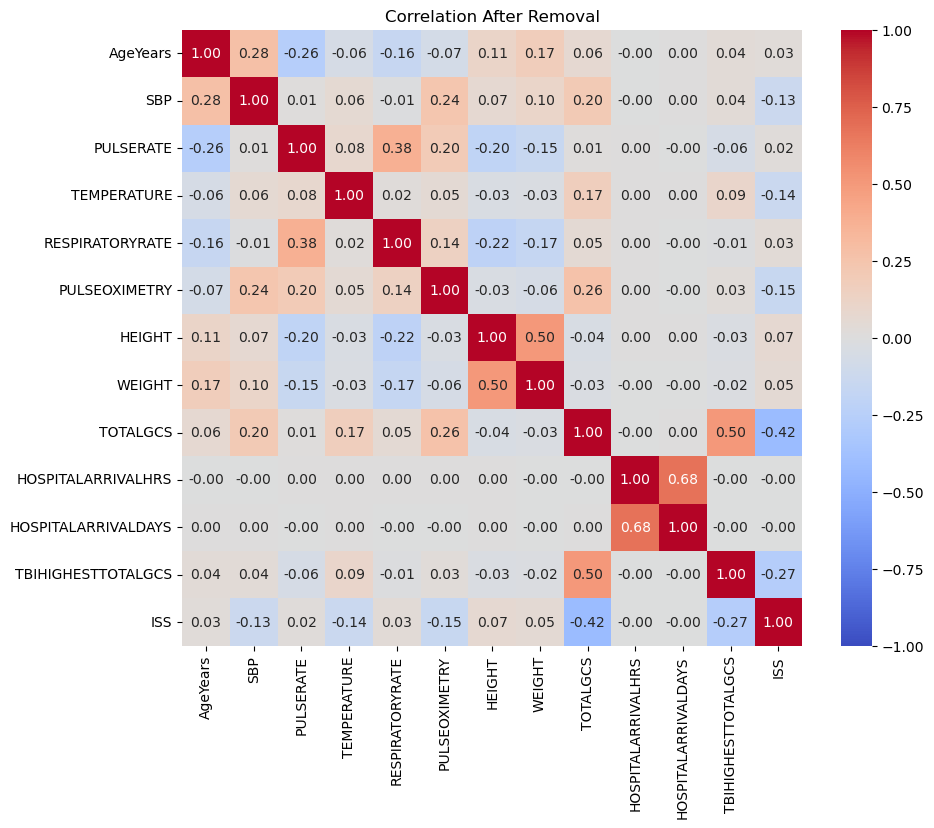

(1232956, 73)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# multicolinearity and related?
# also by the end will need to update the oh, binary, numeric, and label lists to stuff actually in the data. removed a ton after all

number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# get corr matrix
correlation_matrix = trauma_preprocessed[number_features].corr()

# Identify high correlation (above 0.9)
threshold = 0.9
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)
highly_correlated_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                           for x, y in zip(*highly_correlated) if x != y and x < y]

# Display highly correlated pairs
print("Highly correlated pairs (above 0.9 correlation):")
for pair in highly_correlated_pairs:
    print(pair)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Before Removal")
plt.show()

# Optionally: Drop one variable from each highly correlated pair
# Example of dropping 'feature2' from highly correlated pair ('feature1', 'feature2')

drop_correlated = ['GCSMOTOR','GCSEYE','GCSVERBAL','GCSMOTOR','TBIGCSMOTOR']
trauma_preprocessed = trauma_preprocessed.drop(columns=drop_correlated)

# update number_features
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]


# get corr matrix
correlation_matrix = trauma_preprocessed[number_features].corr()



# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
plt.title("Correlation After Removal")
plt.show()


trauma_preprocessed.shape

In [17]:
# multicolinearity for numbers:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Add constant to data for VIF calculation (intercept term)
data_with_const = add_constant(trauma_preprocessed[number_features])

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Step 3: Filter out features with high VIF (>10 for high multicollinearity)
high_vif_threshold = 10

# drop const as not in trauma_preprocesseed
i = vif_data[((vif_data.feature == 'const'))].index
vif_data = vif_data.drop(i)

features_to_drop = vif_data[vif_data["VIF"] > high_vif_threshold]["feature"].tolist()

# Step 4: Drop high VIF features from the DataFrame
trauma_preprocessed = trauma_preprocessed.drop(columns=features_to_drop)

# Display the results

print("\nFeatures with high VIF (VIF > 10):", features_to_drop)
print("\nDataFrame after dropping high VIF features:")
print(trauma_preprocessed.shape)



Features with high VIF (VIF > 10): []

DataFrame after dropping high VIF features:
(1232956, 73)


In [18]:
i = vif_data[((vif_data.feature == 'const'))].index

test = vif_data.drop(i)
vif_data

,feature,VIF
1,AgeYears,1.216293
2,SBP,1.211668
3,PULSERATE,1.291924
4,TEMPERATURE,1.047282
5,RESPIRATORYRATE,1.218881
6,PULSEOXIMETRY,1.195863
7,HEIGHT,1.391611
8,WEIGHT,1.371941
9,TOTALGCS,1.663883
10,HOSPITALARRIVALHRS,1.854661


In [19]:
# since we need the lists above for encoding, will filter to use only ones still existing:

binary_features = [col for col in binary_features if col in trauma_preprocessed.columns]
onehot_features = [col for col in onehot_features if col in trauma_preprocessed.columns]
label_features =  [col for col in label_features if col in trauma_preprocessed.columns]
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# print(binary_features)
trauma_preprocessed.shape

(1232956, 73)

In [20]:
# encoding and scaling
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

print(trauma_preprocessed.shape)

# drop inc_key as not needed
trauma_preprocessed = trauma_preprocessed.drop(columns=['inc_key'])

preprocessor = ColumnTransformer(
    transformers=[
        # 1. One-Hot Encoding for categorical features
        ('onehot', OneHotEncoder(drop=None), onehot_features),
        
        # 2. Ordinal Encoding for binary/label features
        ('label', OrdinalEncoder(), binary_features + label_features),
        
        # 3. Standardization for continuous features
        ('scaler', StandardScaler(), number_features)
    ],
    remainder='passthrough'  # Keep any other columns in the DataFrame, if needed
)

# Fit and transform the data
processed_data = preprocessor.fit_transform(trauma_preprocessed)

# Create a DataFrame with transformed features
transformed_trauma = pd.DataFrame(processed_data, columns=preprocessor.get_feature_names_out())

# Response variable encoding
# transformed_trauma['transfusion'] = LabelEncoder().fit_transform(trauma_preprocessed['transfusion'])



print(transformed_trauma.shape)
print(transformed_trauma.columns.tolist())


(1232956, 73)
(1232956, 80)
['onehot__SEX_1.0', 'onehot__SEX_2.0', 'onehot__SEX_3.0', 'onehot__ETHNICITY_1.0', 'onehot__ETHNICITY_2.0', 'onehot__TBIMIDLINESHIFT_1.0', 'onehot__TBIMIDLINESHIFT_2.0', 'onehot__TBIMIDLINESHIFT_3.0', 'onehot__TEACHINGSTATUS_1.0', 'onehot__TEACHINGSTATUS_5.0', 'onehot__TEACHINGSTATUS_6.0', 'label__ASIAN', 'label__BLACK', 'label__ETHNICITY', 'label__RACEOTHER', 'label__WHITE', 'label__RACE_UK', 'label__WORKRELATED', 'label__PROTDEV_NONE', 'label__PROTDEV_LAP_BELT', 'label__PROTDEV_HELMET', 'label__PROTDEV_AIRBAG_PRESENT', 'label__PROTDEV_SHOULDER_BELT', 'label__PROTDEV_UK', 'label__AIRBAG_NOTDEPLOYED', 'label__AIRBAG_DEPLOYED_FRNT', 'label__AIRBAG_DEPLOYED_SIDE', 'label__AIRBAG_DEPLOYED_NA', 'label__AIRBAG_DEPLOYED_UK', 'label__TRANSPORTMODE', 'label__TM_GROUNDAMBULANCE', 'label__TM_PRIVPUBVEHWALKIN', 'label__TM_NA', 'label__TM_UK', 'label__INTERFACILITYTRANSFER', 'label__PREHOSPITALCARDIACARREST', 'label__RESPIRATORYASSISTANCE', 'label__GCSQ_SEDATEDPARALYZED

In [21]:
# export df into a csv for ease of use in future

# rename transfusion column for convenience
transformed_trauma = transformed_trauma.rename(columns={'remainder__transfusion': 'transfusion'})

# Assuming your DataFrame is named 'trauma_preprocessed_final'
transformed_trauma.to_csv("trauma_preprocessed_final.csv", index=True)

# Replace 'column1' and 'column2' with the actual column names
# are_identical = transformed_trauma['remainder__transfusion'].equals(transformed_trauma['transfusion'])

# print("Are the columns identical?", are_identical)


# Model training
Will first use a small model trained on 10,000 units before full set.

In [20]:
# making a small dataset to test models easier
# Set random seed for reproducibility
np.random.seed(42)

# Number of rows to selecte
n = 10000

# Randomly select n rows
trauma_preprocessed_small= trauma_preprocessed.sample(n=n, random_state=42)

# Display the first few rows of the sampled DataFrame
print(trauma_preprocessed_small.shape)

(10000, 73)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix



# Define the preprocessing steps for categorical and continuous features

# temp solution just drop the cat features. dont seem physiologically important, lets prototype this
# there are several continuous vars that will need to be binarized or made into categoricals though



# Separate the features (X) and the target variable (y)
X = trauma_preprocessed_small.drop('transfusion', axis=1)
y = trauma_preprocessed_small['transfusion']


# X_imputed = mode_imputer.fit_transform(X)

# Standardize the continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# try doing the multiple encodings: OH, label, binary
# do we need to standardize

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)






# Model tuning
Now that you got some good pre-processing done, you will need to do the model fine tuning. look at what each of them can do, and what is significant, etc. basically find the one that works the best given all this data you got.

In [22]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2704   27]
 [ 246   23]]

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95      2731
        True       0.46      0.09      0.14       269

    accuracy                           0.91      3000
   macro avg       0.69      0.54      0.55      3000
weighted avg       0.88      0.91      0.88      3000



In [23]:
# now lets try decision tree classifiers
from sklearn import tree

y_binary = y.astype(int)

X_train, X_test, y_train_b, y_test_b = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train_b)

clf_pred = clf.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test_b, clf_pred))
print("\nClassification Report:")
print(classification_report(y_test_b, clf_pred))

Confusion Matrix:
[[2507  224]
 [ 174   95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2731
           1       0.30      0.35      0.32       269

    accuracy                           0.87      3000
   macro avg       0.62      0.64      0.62      3000
weighted avg       0.88      0.87      0.87      3000



In [24]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train_b)

lr_pred = lr.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test_b, lr_pred))
print("\nClassification Report:")
print(classification_report(y_test_b, lr_pred))

Confusion Matrix:
[[2699   32]
 [ 212   57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2731
           1       0.64      0.21      0.32       269

    accuracy                           0.92      3000
   macro avg       0.78      0.60      0.64      3000
weighted avg       0.90      0.92      0.90      3000



In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_b)

# Predict and evaluate
rf_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test_b, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test_b, rf_pred))


Confusion Matrix:
[[2717   14]
 [ 228   41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2731
           1       0.75      0.15      0.25       269

    accuracy                           0.92      3000
   macro avg       0.83      0.57      0.61      3000
weighted avg       0.91      0.92      0.89      3000



In [26]:
# support vector machines
from sklearn.svm import SVC

# Create and train the model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train_b)

# Predict and evaluate
svm_pred = svm.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test_b, svm_pred))
print("\nClassification Report:")
print(classification_report(y_test_b, svm_pred))


Confusion Matrix:
[[2731    0]
 [ 269    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2731
           1       0.00      0.00      0.00       269

    accuracy                           0.91      3000
   macro avg       0.46      0.50      0.48      3000
weighted avg       0.83      0.91      0.87      3000



c:\Users\micha\anaconda3\envs\trauma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\micha\anaconda3\envs\trauma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\micha\anaconda3\envs\trauma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
